In [423]:
import base64
import concurrent.futures as cf
from collections import defaultdict, deque
import copy
import io
import math
from pathlib import Path
import pickle
import time
import warnings

import concurrent.futures as cf
from confugue import Configuration
import IPython.display as ipd
import muspy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import make_interp_spline
import scipy.spatial.distance
import torch
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm

from spe_music.model.music_performer import MusicPerformer
from spe_music.model import fast_transformer_decoder
from spe_music.style_eval import style_profiles
from spe_music.train_performer_grv2grv import make_representation

In [500]:
sns.set_style("darkgrid")
sns.set(font_scale=1.1)

In [379]:
DATA_PATH = Path('../data/train_split')
STYLE_PROFILE_CFG_PATH = 'style_eval_config.yaml'
STYLE_PROFILE_DRUMS_CFG_PATH = 'style_eval_drums_config.yaml'

In [380]:
def cosine_similarity(hist1, hist2):
    return 1. - scipy.spatial.distance.cosine(hist1.reshape(1, -1), hist2.reshape(1, -1))

In [381]:
def split_by_index(musics, num_segments):
    result = []
    for i in range(num_segments):
        result.append([])
        for music in musics:
            music = copy.deepcopy(music)
            for track in music.tracks:
                track.notes.sort(key=lambda n: n.time)
                s = len(track.notes) // num_segments
                if i < num_segments - 1:
                    track.notes[:] = track.notes[i * s:(i + 1) * s]
                else:
                    track.notes[:] = track.notes[i * s:]
            result[-1].append(music)
    return result

In [382]:
def split_by_time(musics, num_segments):
    result = []
    for i in range(num_segments):
        result.append([])
        for music in musics:
            music = copy.deepcopy(music)
            s = music.get_end_time() // num_segments
            for track in music.tracks:
                if track.notes:
                    track.notes.sort(key=lambda n: n.time)
                    track.notes[:] = [n for n in track.notes
                                      if n.start >= i * s and n.start <= (i + 1) * s ]
            result[-1].append(music)
    return result

In [383]:
def split_by_track(musics):
    result = defaultdict(list)
    for music in musics:
        for i in range(len(music.tracks)):
            music_track = copy.deepcopy(music)
            music_track.tracks[:] = music_track.tracks[i:i+1]
            result[i].append(music_track)
    return dict(result)

In [4]:
with open(STYLE_PROFILE_CFG_PATH, 'rb') as f:
    STYLE_PROFILE_FN = Configuration.from_yaml(f).bind(style_profiles.extract_all_stats)
with open(STYLE_PROFILE_DRUMS_CFG_PATH, 'rb') as f:
    STYLE_PROFILE_DRUMS_FN = Configuration.from_yaml(f).bind(style_profiles.extract_all_stats)

def evaluate_style(musics, ref_musics, is_drum=False, separate_drums=False):
    """Evaluate the style similarity of two sets of musics."""
    extract_fn = STYLE_PROFILE_FN if not is_drum else STYLE_PROFILE_DRUMS_FN
    stats = extract_fn(data=musics)
    ref_stats = extract_fn(data=ref_musics)
    metrics = {name + ('_drums' if is_drum and separate_drums else ''):
                   cosine_similarity(stats[name], ref_stats[name])
               for name in stats if name in ref_stats}

    return metrics

In [5]:
dataset = muspy.MusicDataset(DATA_PATH / 'test')

In [59]:
style_refs = {}
for music in dataset:
    _, style = music.metadata.title.split('.', maxsplit=1)
    assert style not in style_refs
    music.tracks[2:] = sorted(music.tracks[2:], key=lambda tr: -len(tr.notes))
    music.tracks[:] = music.tracks[:3]
    style_refs[style] = music

In [384]:
outputs = {}
for model_dir in ['trio_performer_softmax_l512_v01', 'trio_performer_softmax_sinespe_l512_v01', 'trio_performer_softmax_convspe_l512_v01']:
    outputs[model_dir] = defaultdict(list)
    for output_path in sorted(Path(model_dir).glob('outputs/*.cont_*.mid')):
        _, style, cont_id, _ = output_path.name.split('.')
        outputs[model_dir][style].append(muspy.read_midi(output_path))

In [ ]:
results = defaultdict(list)

def eval_model_style(model_dir, style):
    results = []
    style_ref_tracks = split_by_track([style_refs[style]])

    output_tracks = split_by_track(outputs[model_dir][style])
    for i in style_ref_tracks:
        segments = split_by_time(output_tracks.get(i, []), 4)
        for j in range(len(segments)):
            result = evaluate_style(
                segments[j],
                style_ref_tracks[i],
                is_drum=style_ref_tracks[i][0].tracks[0].is_drum)
            for metric, value in result.items():
                results.append({
                    'style': style,
                    'track': track_name,
                    'segment': j,
                    'metric': metric,
                    'value': value})
    return results

with cf.ProcessPoolExecutor(12) as pool:
    futures = {}
    for model_dir in outputs.keys():
        futures[model_dir] = []
        for style in style_refs.keys():
            futures[model_dir].append(pool.submit(eval_model_style, model_dir, style))
    
    results = {model_dir: [r for f in tqdm(cf.as_completed(future_list), total=len(future_list)) for r in f.result()]
               for model_dir, future_list in futures.items()}

In [390]:
results_df_long = pd.DataFrame([{'model': model, **r} for model, model_results in results.items() for r in model_results])
results_df_long = results_df_long.groupby(['model', 'style', 'segment', 'metric']).mean().drop('track', axis=1).reset_index()
results_df_long

,model,style,segment,metric,value
0,trio_performer_softmax_convspe_l512_v01,AG_MORT_a,0,onset.drum,0.296737
1,trio_performer_softmax_convspe_l512_v01,AG_MORT_a,0,onset.duration,0.031305
2,trio_performer_softmax_convspe_l512_v01,AG_MORT_a,0,time_pitch_diff,0.353557
3,trio_performer_softmax_convspe_l512_v01,AG_MORT_a,1,onset.drum,0.296737
4,trio_performer_softmax_convspe_l512_v01,AG_MORT_a,1,onset.duration,0.000000
...,...,...,...,...,...
1783,trio_performer_softmax_sinespe_l512_v01,YEARN_b,2,onset.duration,0.600120
1784,trio_performer_softmax_sinespe_l512_v01,YEARN_b,2,time_pitch_diff,0.566716
1785,trio_performer_softmax_sinespe_l512_v01,YEARN_b,3,onset.drum,0.963180
1786,trio_performer_softmax_sinespe_l512_v01,YEARN_b,3,onset.duration,0.006480


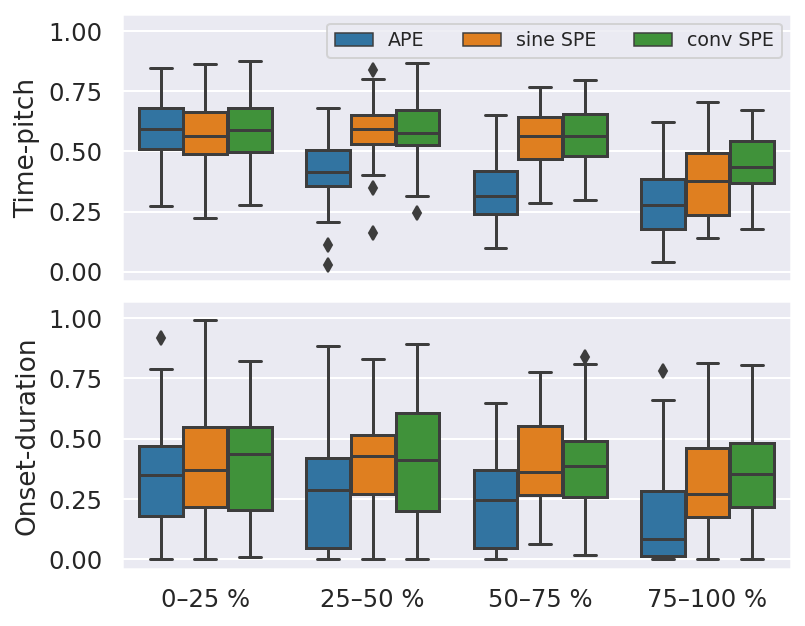

In [522]:
fig, axes = plt.subplots(2, 1, figsize=(6, 5.1), sharey=True, gridspec_kw=dict(hspace=0.075))
for (metric, metric_name), ax in zip([('time_pitch_diff', 'Time-pitch'),
                                      ('onset.duration', 'Onset-duration'),
                                      #('onset.drum', 'Onset-drum')
                                     ], axes):
    sns.boxplot(data=results_df_long[results_df_long['metric'] == metric],
                hue='model', x='segment', y='value', ax=ax, palette=np.array(sns.color_palette('Paired'))[[1, 7, 3]],
                hue_order=['trio_performer_softmax_l512_v01', 'trio_performer_softmax_sinespe_l512_v01', 'trio_performer_softmax_convspe_l512_v01'])
    handles, _ = ax.get_legend_handles_labels()
    ax.set_ylim(-0.04, 1.07)
    ax.set_xlabel(None)
    ax.set_ylabel(metric_name)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.get_legend().remove()
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['0–25 %', '25–50 %', '50–75 %', '75–100 %'])
axes[0].legend(handles, ['APE', 'sine SPE', 'conv SPE'], ncol=4,
               prop={'size': 9.5}, loc='upper right')
plt.savefig('figs/style_eval.pdf', bbox_inches='tight', pad_inches=0)
plt.show()